### Practice: Large Language Models and Their Implications
<!-- ![img](https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fbucketeer-e05bbc84-baa3-437e-9518-adb32be77984.s3.amazonaws.com%2Fpublic%2Fimages%2F4470ce74-e595-4750-92a5-5f21f040df6d_577x432.jpeg) -->
![img](https://i.imgur.com/QGYa2J8.jpeg)

In this notebook, you're gonna play with some of the largest language models on the Internet.

_Based on works of: Tim Dettmers, Ruslan Svirschevsky, Artem Chumachenko, Younes Belkada, Felix Marty, Yulian Gilyazev, Gosha Zolotov, Andrey Ishutin,  Elena Volf, Artemiy Vishnyakov, Svetlana Shirokovskih.

### Part 1: prompt engineering (4 points total)

In the assignment, we'll use public APIs that host the 100B+ models for inference. Your task is to prompt-engineer the model into solving a few tasks for you.


__Which API?__ You are free to use any publicly available API for general LM -- as long as it's __not a chat assistant__. So, gpt 3.5 is fine, but chatGPT is not. Here's a few options:

- BLOOM API - [bigscience/bloom](https://huggingface.co/bigscience/bloom) (on the right; recommended)
- OpenAI API (via VPN) - [openai.com/api](https://openai.com/api/)
- AI21 Jurrasic API - [ai21.com](https://www.ai21.com/blog/announcing-ai21-studio-and-jurassic-1)

These APIs may require you to create a (free) account on their platform. Please note that some APIs also have paid subscriptions. __You do not need to pay them__, this assignment was designed to be solved using free-tier subscriptions. If no APIs work for you, you can also solve these tasks with the 6.7B model that you will find later in this notebook - but this will make the tasks somewhat harder.

__Quests:__ you will need to solve 4 problems. For each one, please attach a short __description__ of your solution and a __screenshot__ from the API you use. _[If you use python APIs, show your python code with outputs]_

__Example:__ Tony is talking to Darth Vader ([BLOOM API](https://huggingface.co/bigscience/bloom)). Black text is written manually, blue text is generated.
<hr>

![img](https://i.imgur.com/a1QhKF7.png)
<hr>

__It is fine to roll back a few times,__ e.g. in the example above, the model first generated Vader lines twice in a row, and we rolled that back. However, if you need more than 1-2 rollbacks per session, you should probably try a different prompt.

__Task 1 (1 pt):__ arange a conversation between any two of the following:

- a celebrity or politician of your choice
- any fictional character (except Darth Vader)
- yourself

Compare two setups: a) you prompt with character names only b) you supply additional information (see example).

a)

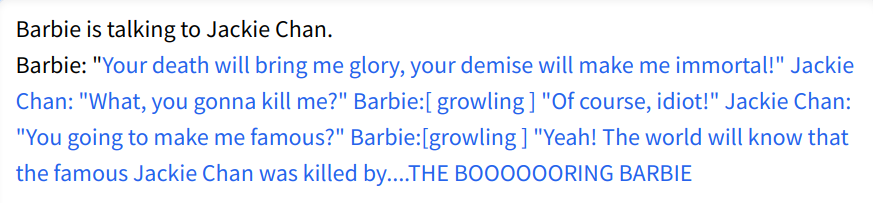

b)

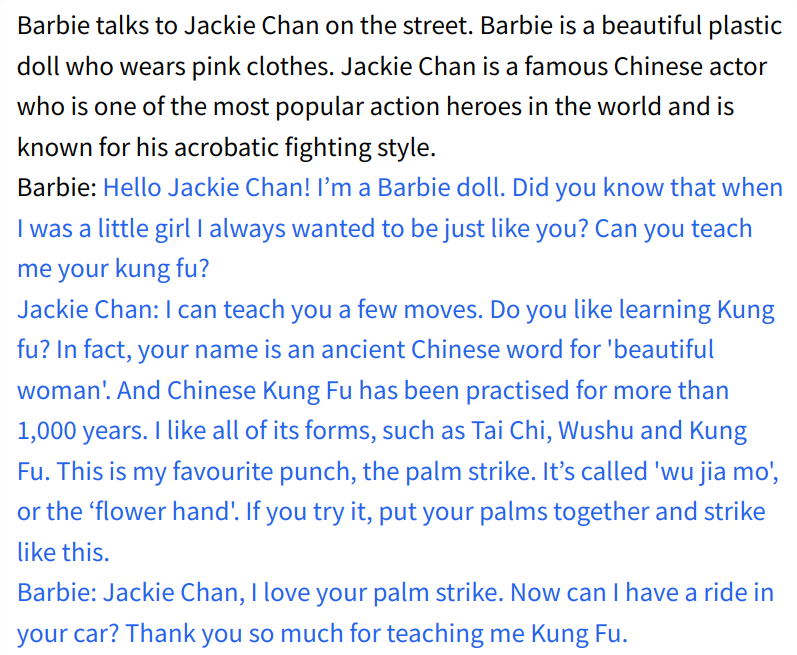

__Please choose task 2a or 2b (1pt)__ depending on your model (you can do both, but you will be awarded points for one of these two tasks).

__Task 2a: (for BLOOM or other multilingual model)__ zero-shot translation. Take the first verse of [Edgar Allan Poe's "Raven"](https://www.poetryfoundation.org/poems/48860/the-raven) and __translate it into French.__ (You are free to use any other text of at least the same size)

Original text: ```
Once upon a midnight dreary, while I pondered, weak and weary,
Over many a quaint and curious volume of forgotten lore—
    While I nodded, nearly napping, suddenly there came a tapping,
As of some one gently rapping, rapping at my chamber door.
“’Tis some visitor,” I muttered, “tapping at my chamber door—
            Only this and nothing more.”
```

Verify your translation by converting french back into english using a public machine translation service.

__Task 2b: (non-BLOOM):__ toxicity classification for [SetFit/toxic_conversations](https://huggingface.co/datasets/SetFit/toxic_conversations). Make the model solve binary classification (toxic vs not toxic) in the few shot mode. For few-shot examples, use 2-3 toxic and 2-3 non-toxic non-toxic examples. Measure accuracy on at least 25 samples. You may need to try several different prompts before you find the one that works.

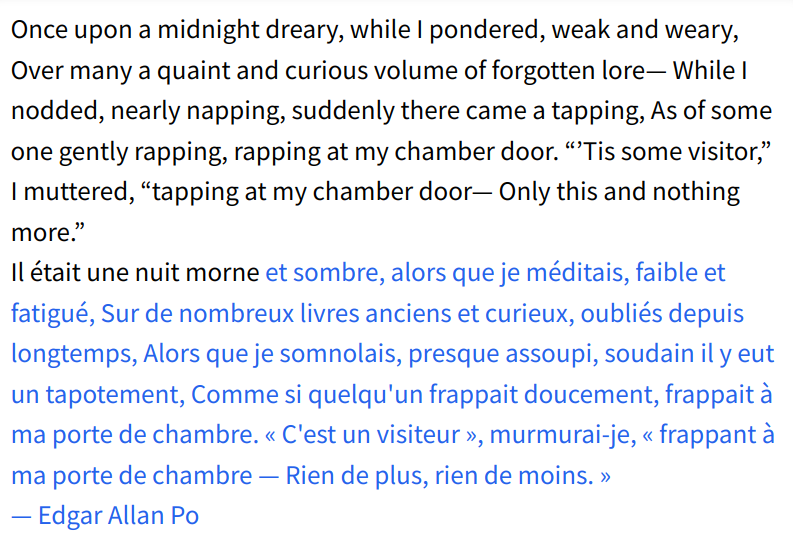


__Task 3 (1pt):__ create a prompt and few-shot examples tha make the model __change the gender pronouns__ of the main actor in a given sentence in any direction of your choice. E.g. the doctor took off _his_ mask <-> the doctor took of _her_ mask.


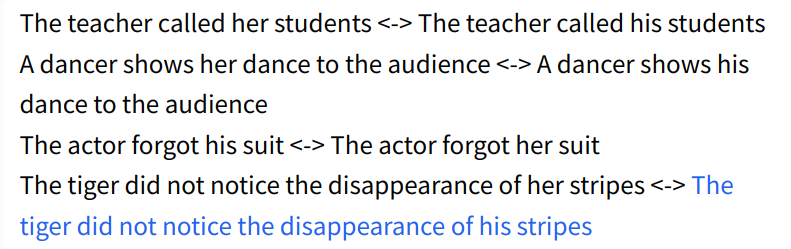

__Task 4 (1pt):__ write a prompt and supply examples such that the model would __convert imperial units to metric units__ (miles -> kilometers; mph -> kph). More specifically, the model should rewrite a given sentence and replace all imperial units with their metric equivalents. After it works with basic distances and speed, try to find complicated examples where it does *not* work.

Please note that 1 mile is not equal to 1 km :)

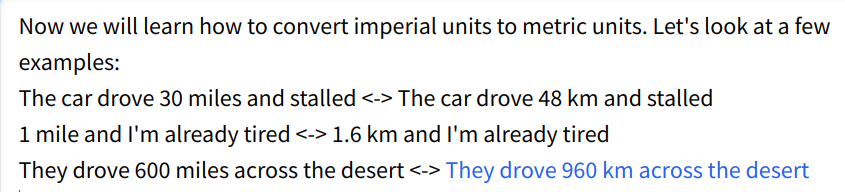

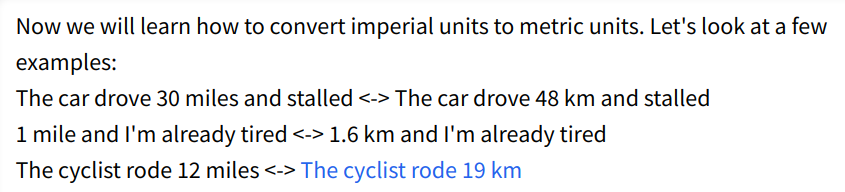

Right answer is 187 kph

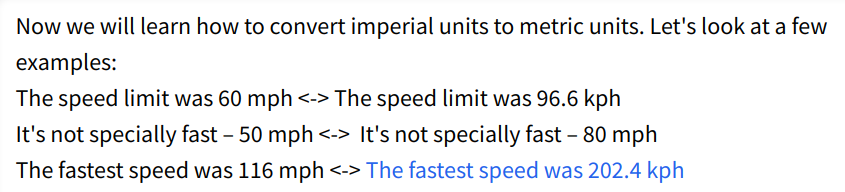

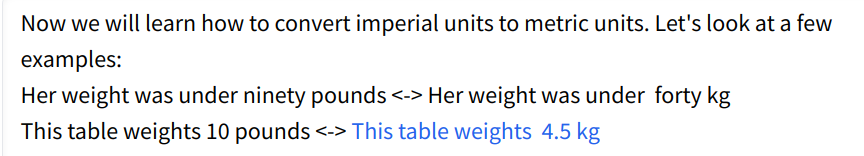

### Part 2: local inference

Now, let's try and load the strongest model that can fit a typical Colab GPU (T4 with 16 GB as of spring 2023).

Our best candidates are the smaller versions of the best performing open source models:
- 7 Bn parameters version of [LLaMA](https://arxiv.org/pdf/2302.13971.pdf) - best for spring 2023, released by Facebook
- 7 Bn parameters version of [Falcon](https://falconllm.tii.ae) - close competitor to Llama, released in May 2023 by [Technology Innovation Institute of UAE](https://www.tii.ae).
- 6.7 Bn parameters version of [OPT](https://arxiv.org/abs/2205.01068) - top choice in this nomination in 2022, released by Facebook.

Beware: while these models are smaller than the ones in API, they're still over 60x larger than the BERT we played with last time. The code below will *just barely* fit into memory, so make sure you don't have anything else loaded. Sometimes you may need to restart runtime for the code to work.

It's a good time to restart your kernel and switch to GPU! (Runtime -> Change runtime type)
<center><img src="https://i.imgur.com/OOfDYzJ.png" width=240px></center>

In [ ]:
%pip install --quiet bitsandbytes==0.41.1 transformers==4.34.1 accelerate==0.24.0 sentencepiece==0.1.99 optimum==1.13.2 auto-gptq==0.4.2
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
import bitsandbytes as bnb
from tqdm.auto import tqdm, trange
assert torch.cuda.is_available(), "you need cuda for this part"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model_name = 'TheBloke/Llama-2-13B-GPTQ'

# loading Llama tokenizer ...
tokenizer = transformers.LlamaTokenizer.from_pretrained(model_name, device_map=device)
tokenizer.pad_token_id = tokenizer.eos_token_id

# ... and the model itself
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map='auto',
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    offload_state_dict=True
)

## Text generation

**Comparison of strategies for language model text generation:**

| Strategy | Description | Pros & Cons |
| --- | --- | --- |
| Greedy Search | Chooses the word with the highest probability as the next word in the sequence. | **Pros:** Simple and fast. <br> **Cons:** Can lead to repetitive and incoherent text. |
| Sampling with Temperature | Introduces randomness in the word selection. A higher temperature leads to more randomness. | **Pros:** Allows exploration and diverse output. <br> **Cons:** Higher temperatures can lead to nonsensical outputs. |
| Nucleus Sampling (Top-p Sampling) | Selects the next word from a truncated vocabulary, the "nucleus" of words that have a cumulative probability exceeding a pre-specified threshold (p). | **Pros:** Balances diversity and quality. <br> **Cons:** Setting an optimal 'p' can be tricky. |
| Beam Search | Explores multiple hypotheses (sequences of words) at each step, and keeps the 'k' most likely, where 'k' is the beam width. | **Pros:** Produces more reliable results than greedy search. <br> **Cons:** Can lack diversity and lead to generic responses. |
| Top-k Sampling | Randomly selects the next word from the top 'k' words with the highest probabilities. | **Pros:** Introduces randomness, increasing output diversity. <br> **Cons:** Random selection can sometimes lead to less coherent outputs. |
| Length Normalization | Prevents the model from favoring shorter sequences by dividing the log probabilities by the sequence length raised to some power. | **Pros:** Makes longer and potentially more informative sequences more likely. <br> **Cons:** Tuning the normalization factor can be difficult. |
| Stochastic Beam Search | Introduces randomness into the selection process of the 'k' hypotheses in beam search. | **Pros:** Increases diversity in the generated text. <br> **Cons:** The trade-off between diversity and quality can be tricky to manage. |
| Decoding with Minimum Bayes Risk (MBR) | Chooses the hypothesis (out of many) that minimizes expected loss under a loss function. | **Pros:** Optimizes the output according to a specific loss function. <br> **Cons:** Computationally more complex and requires a good loss function. |

Documentation references:
- [reference for `AutoModelForCausalLM.generate()`](https://huggingface.co/docs/transformers/v4.29.1/en/main_classes/text_generation#transformers.GenerationMixin.generate)
- [reference for `AutoTokenizer.decode()`](https://huggingface.co/docs/transformers/main_classes/tokenizer#transformers.PreTrainedTokenizer.decode)
- Huggingface [docs on generation strategies](https://huggingface.co/docs/transformers/generation_strategies)

### Generation with HuggingFace

In [3]:
prompt = 'The first discovered martian lifeform looks like'
batch = tokenizer(prompt, return_tensors='pt', return_token_type_ids=False).to(device)
print("Input batch (encoded):", batch)

output_tokens = model.generate(**batch, max_new_tokens=64, do_sample=True, temperature=0.8)
# greedy inference:                                        do_sample=False)
# beam search for highest probability:                     num_beams=4)

print("\nOutput:", tokenizer.decode(output_tokens[0].cpu()))

Input batch (encoded): {'input_ids': tensor([[    1,   450,   937, 10943, 14436,   713,  2834,   689,  3430,   763]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1421: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(



Output: <s>The first discovered martian lifeform looks like a bacteria, and it may have been discovered by two different teams at the same time. The first team, lead by the geologist Charles S. Cockell, have found a structure in the martian soil that they believe contains a cell. The cell is a chain of about 100 carbon


#### Low-level code for text generation

**Task 5: write code for nucleus sampling generation (2 points)**:

Use the `nucleus_sampling()` template below. Look at the detailed generation code above for inspiration. __Please do not use model.generate__.

**Bonus task: write code for beam search (3 bonus points)**

In [60]:
from typing import Tuple, List
import numpy as np

tokens = np.array([word for word in voc])

def nucleus_sampling(model, tokenizer, prompt: str, prob: float = 0.5) -> Tuple[str, List[str]]:
    """generates the next token from the nucleus of tokens with cumulative probability up to param:prob"""

    batch1 = tokenizer(prompt, return_tensors='pt', return_token_type_ids=False).to(device)
    logits = model.forward(**batch1).logits[0, -1, :]
    probs = torch.nn.functional.softmax(logits, dim=-1).detach().cpu().numpy()

    sorted_indices = np.argsort(probs)[::-1]
    sorted_probs = np.cumsum(sorted(probs, reverse=True)) < prob

    mask = np.zeros(len(probs), dtype=bool)
    mask[sorted_indices] = sorted_probs

    new_probs = probs.copy()
    new_probs[~mask] = 0.
    possible_tokens = np.arange(len(probs))[mask]
    possible_tokens = [tokenizer.decode(t) for t in possible_tokens]

    if (s:= sum(new_probs)):
        new_probs /= s
        sampled_token = np.random.choice(np.arange(len(probs)), p=new_probs)
    else:
        sampled_token = np.random.choice(np.arange(len(probs)), p=probs)

    # sampled_token should be a string token that was generated
    # possible_tokens should be a list of all tokens that have non-zero probability
    return tokenizer.decode(sampled_token), possible_tokens

In [61]:
# Tests for nucleus sampling
test_prompt = "Elbrus is the highest"
next_token, possible_tokens = nucleus_sampling(model, tokenizer, test_prompt, prob=0.9)
print(test_prompt, next_token, possible_tokens)
assert next_token in possible_tokens
assert 3 <= len(possible_tokens) <= 3
assert sorted(possible_tokens) == ['mountain', 'peak', 'point']

test_prompt = "Large language models can learn to"
next_token, possible_tokens = nucleus_sampling(model, tokenizer, test_prompt, prob=0.4)
print(test_prompt, next_token, possible_tokens)
assert next_token in possible_tokens
assert sorted(possible_tokens) == ['be', 'communicate', 'do', 'generate', 'perform', 'predict', 'speak', 'write']
assert len(possible_tokens) == 8

Elbrus is the highest peak ['point', 'mountain', 'peak']
Large language models can learn to write ['be', 'do', 'perform', 'write', 'generate', 'speak', 'predict', 'communicate']


### Part 3: Chain-of-thought prompting (4 points total)

![img](https://github.com/kojima-takeshi188/zero_shot_cot/raw/main/img/image_stepbystep.png)

---



In [62]:
import json
import random
import locale; locale.getpreferredencoding = lambda: "UTF-8"
!wget https://raw.githubusercontent.com/kojima-takeshi188/zero_shot_cot/2824685e25809779dbd36900a69825068e9f51ef/dataset/AQuA/test.json -O aqua.json
data = list(map(json.loads, open("aqua.json")))

--2023-11-04 12:01:38--  https://raw.githubusercontent.com/kojima-takeshi188/zero_shot_cot/2824685e25809779dbd36900a69825068e9f51ef/dataset/AQuA/test.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130192 (127K) [text/plain]
Saving to: ‘aqua.json’

aqua.json           100%[===================>] 127.14K  --.-KB/s    in 0.02s   

2023-11-04 12:01:38 (6.41 MB/s) - ‘aqua.json’ saved [130192/130192]



In [63]:
print("Example:")
data[150]

Example:


{'question': 'Janice bikes at 10 miles per hour, while Jennie bikes at 20. How long until they have collectively biked 1 mile?',
 'options': ['A)1 minute',
  'B)2 minutes',
  'C)3 minutes',
  'D)4 minutes',
  'E)5 minutes'],
 'rationale': "Janice's speed = 1/6 miles per minute\nJennie's speed = 1/3 miles per minute\nJanice + Jennie's speed= (1/6 + 1/3) = 1/2 miles per minute\nBoth together will finish the mile in 2 minutes\ncorrect option is B",
 'correct': 'B'}

### Naive solution

Here, we prompt the model to choose an answer to the example above (`data[150]`) out of the options given above. We're using a format that mimics grade school solution textbook.

Please note that there are minor formatting changes in options: an extra space and an opening bracket. Those may or may not be important :)

In [64]:
EXAMPLE_0SHOT = """
Question: Janice bikes at 10 miles per hour, while Jennie bikes at 20. How long until they have collectively biked 1 mile?
Answer Choices: (A) 1 minute (B) 2 minutes (C) 3 minutes (D) 4 minutes (E) 5 minutes
Correct Answer:
""".strip()

In [66]:
# solving an equation directly
batch = tokenizer(EXAMPLE_0SHOT, return_tensors='pt', return_token_type_ids=False).to(device)
torch.manual_seed(1337)
output_tokens = model.generate(**batch, max_new_tokens=100, do_sample=True, top_p=0.9)
print("[Prompt:]\n" + EXAMPLE_0SHOT)
print("=" * 80)
print("[Generated:]", tokenizer.decode(output_tokens[0][batch['input_ids'].shape[1]:].cpu()))

[Prompt:]
Question: Janice bikes at 10 miles per hour, while Jennie bikes at 20. How long until they have collectively biked 1 mile?
Answer Choices: (A) 1 minute (B) 2 minutes (C) 3 minutes (D) 4 minutes (E) 5 minutes
Correct Answer:
[Generated:] (E) 5 minutes
Explanation: Jennie bikes at 20 miles per hour for 2 minutes. She will have travelled 2 miles in this time. Janice also bikes for 2 minutes, but at a slower speed of 10 miles per hour. This means that she will travel 2/10 miles or 0.2 miles. She will travel 1 mile in 5 minutes. Hence, 5 minutes will have el


And here's how you can solve this with few-shot chain-of-thought prompting.

You need to chang 3 things
- use a new field called **Rationale**, that contains a step-by-step solution to the problem
- add several few-shot examples of previously solved problems **with rationales**
- change the final prompt so that the model has to generate rationale before answering

In [67]:
EXAMPLE_3SHOT_CHAIN_OF_THOUGHT = """
Question: The original retail price of an appliance was 60 percent more than its wholesale cost. If the appliance was actually sold for 20 percent less than the original retail price, then it was sold for what percent more than its wholesale cost?
Answer Choices: (A) 20% (B) 28% (C) 36% (D) 40% (E) 42%
Rationale: wholesale cost = 100;\noriginal price = 100*1.6 = 160;\nactual price = 160*0.8 = 128.\nAnswer: B.
Correct Answer: B


Question: A grocer makes a 25% profit on the selling price for each bag of flour it sells. If he sells each bag for $100 and makes $3,000 in profit, how many bags did he sell?
Answer Choices: (A) 12 (B) 16 (C) 24 (D) 30 (E) 40
Rationale: Profit on one bag: 100*1.25= 125\nNumber of bags sold = 3000/125 = 24\nAnswer is C.
Correct Answer: C


Question: 20 marbles were pulled out of a bag of only white marbles, painted black, and then put back in. Then, another 20 marbles were pulled out, of which 1 was black, after which they were all returned to the bag. If the percentage of black marbles pulled out the second time represents their percentage in the bag, how many marbles in total Q does the bag currently hold?
Answer Choices: (A) 40 (B) 200 (C) 380 (D) 400 (E) 3200
Rationale: We know that there are 20 black marbles in the bag and this number represent 1/20 th of the number of all marbles in the bag, thus there are total Q of 20*20=400 marbles.\nAnswer: D.
Correct Answer: D


Question: Janice bikes at 10 miles per hour, while Jennie bikes at 20. How long until they have collectively biked 1 mile?
Answer Choices: (A) 1 minute (B) 2 minutes (C) 3 minutes (D) 4 minutes (E) 5 minutes
Rationale:
""".strip()

In [68]:
batch = tokenizer(EXAMPLE_3SHOT_CHAIN_OF_THOUGHT, return_tensors='pt', return_token_type_ids=False).to(device)
torch.manual_seed(1337)
output_tokens = model.generate(**batch, max_new_tokens=100, do_sample=True, top_p=0.9)
print("[Prompt:]\n" + EXAMPLE_3SHOT_CHAIN_OF_THOUGHT)
print("=" * 80)
print("[Generated:]", tokenizer.decode(output_tokens[0][batch['input_ids'].shape[1]:].cpu()))
#### NOTE: scroll down for the final answer (below the ======= line)

[Prompt:]
Question: The original retail price of an appliance was 60 percent more than its wholesale cost. If the appliance was actually sold for 20 percent less than the original retail price, then it was sold for what percent more than its wholesale cost?
Answer Choices: (A) 20% (B) 28% (C) 36% (D) 40% (E) 42%
Rationale: wholesale cost = 100;
original price = 100*1.6 = 160;
actual price = 160*0.8 = 128.
Answer: B.
Correct Answer: B


Question: A grocer makes a 25% profit on the selling price for each bag of flour it sells. If he sells each bag for $100 and makes $3,000 in profit, how many bags did he sell?
Answer Choices: (A) 12 (B) 16 (C) 24 (D) 30 (E) 40
Rationale: Profit on one bag: 100*1.25= 125
Number of bags sold = 3000/125 = 24
Answer is C.
Correct Answer: C


Question: 20 marbles were pulled out of a bag of only white marbles, painted black, and then put back in. Then, another 20 marbles were pulled out, of which 1 was black, after which they were all returned to the bag. If 

__Task 6 (1 pt)__ write a function that automatically creates chain-of-thought prompts. Follow the instructions from the function docstring.

In [81]:
QUESTION_PREFIX = "Question: "
OPTIONS_PREFIX = "Answer Choices: "
CHAIN_OF_THOUGHT_PREFIX = "Rationale: "
ANSWER_PREFIX = "Correct Answer: "
FEWSHOT_SEPARATOR = "\n\n\n"

def make_prompt(*, main_question, fewshot_examples):
  """
  Your goal is to produce the same prompt as the EXAMPLE_3SHOT_CHAIN_OF_THOUGHT automatically

  For each few-shot question, make sure to follow the following rules:
  1. Each question begins with QUESTION_PREFIX, after which you should print the question without leading/traiiling spaces (if any)
  2. After the question, provide space-separated options. Each option should be put in double brackets, followed by option text, e.g. "(A) 146%"
  3. Then, provide the answer as a single letter (A-E)
  4. Finally, add trailing newlines from FEWSHOT_SEPARATOR

  Your final prompt should contain all fewshot_examples (in order), separated with FEWSHOT_SEPARATOR, then follow with main_question.
  The main_question should contain the question and options formatted the same way as in FEWSHOT_EXAMPLES.
  After that, you should prompt the model to produce an explanation (rationale) for the answer.

  Please make sure your prompt contains no leading/trailing newlines or spaces, same as in EXAMPLE_3SHOT_CHAIN_OF_THOUGHT
  """
  def get_prompt(fewshot_examples):
    result = []
    for e in fewshot_examples:
      question = QUESTION_PREFIX + e['question']
      options = OPTIONS_PREFIX + ' '.join(map(lambda x: '('+ x[:2] + ' '+ x[2:], e['options']))
      rationale = CHAIN_OF_THOUGHT_PREFIX + e['rationale']
      correct = ANSWER_PREFIX + e['correct']
      result.append('\n'.join([question, options, rationale, correct]).strip())
    return FEWSHOT_SEPARATOR.join(result) + FEWSHOT_SEPARATOR

  fewshot_prompt = get_prompt(fewshot_examples)

  question = QUESTION_PREFIX + main_question['question']
  options = OPTIONS_PREFIX + ' '.join(map(lambda x: '('+ x[:2] + ' '+ x[2:], main_question['options']))
  rationale = CHAIN_OF_THOUGHT_PREFIX.strip()
  question_prompt = '\n'.join([question, options, rationale])

  return fewshot_prompt + question_prompt


generated_fewshot_prompt = make_prompt(main_question=data[150], fewshot_examples=(data[30], data[20], data[5]))
assert generated_fewshot_prompt == EXAMPLE_3SHOT_CHAIN_OF_THOUGHT, "prompts don't match"
assert generated_fewshot_prompt != make_prompt(main_question=data[150], fewshot_examples=())
assert generated_fewshot_prompt.endswith(make_prompt(main_question=data[150], fewshot_examples=()))

print("Well done!")

# Hint: if two prompts do not match, you may find it usefull to use https://www.diffchecker.com or similar to find the difference

Well done!


__Task 7 (1 points):__ Evaluate your prompt.

Please run the model on the entire dataset and measure it's accuracy.
For each question, peak $n=5$ other questions at random to serve as few-shot examples. Make sure not to accidentally sample the main_question among few-shot examples. For scientific evaluation, it is also a good practice to split the data into two parts: one for eval, and another for few-shot examples. However, doing so is optional in this homework.

The tricky part is when to stop generating: if you don't control for this, your model can accidentally generate a whole new question - and promptyly answer it :) To make sure you get the correct answer, stop generating tokens when the model is done explaining it's solution. To circumvent this, you need to __stop generating as soon as the model generates Final Answer: [A-E]__
To do so, you can either generate manually (see low-level generation above) or use [transformers stopping criteria](https://discuss.huggingface.co/t/implimentation-of-stopping-criteria-list/20040/2), whichever you prefer.

If you do everything right, the model should be much better than random. However, please __do not expect miracles__: this is far from the best models, and it will perform much worse than an average human.

In [ ]:
NUM_SAMPLES = 0    # use this to count how many samples you evaluated
NUM_RESPONDED = 0  # how many times did the model produce Correct Answer: (letter) in it's response. use as a sanity check.
NUM_CORRECT = 0    # how many times did the model's chosen answer (letter) match the correct answer

In [84]:
def get_batch(data):
    arr = np.arange(len(data))
    i = 0
    while i < len(data):
      batch = data[i:i + BATCH_SIZE]
      few_shot_ids = [np.random.choice(arr[arr != i],  size=5) for i in range(i, i + BATCH_SIZE)]
      i += BATCH_SIZE
      yield batch, [data[i] for i in few_shot_ids]

In [ ]:
BATCH_SIZE = 16
for questions, fewshot_examples in get_batch(data):
    batch = [make_prompt(main_question=questions[i], fewshot_examples=fewshot_examples[i]) for i in range(len(questions))]
    batch1 = tokenizer(batch, return_tensors='pt', return_token_type_ids=False).to(device)
    logits = model.forward(**batch1).logits[0, -1, :]
    probs = torch.nn.functional.softmax(logits, dim=-1)
    next_token_id = torch.multinomial(probs.flatten(), num_samples=1)

    next_token = tokenizer.decode(next_token_id)
    prompt1 += next_token

    ...


# Optionally, consider inferencing multiple sentences in a batch for faster inference;
# If you choose to batch outputs, make sure the results are the same as with batch=1 (using greedy inference)

In [ ]:
print("Responded %%:", NUM_RESPONDED / NUM_SAMPLES)
print("Accuracy (when responded):", NUM_CORRECT / NUM_RESPONDED)
print("Accuracy (overall):", NUM_CORRECT / NUM_SAMPLES)

if NUM_RESPONDED / NUM_SAMPLES < 0.9:
  print("Something is wrong with the evaluation technique (for 5-shot CoT): the model refuses to answer too many questions.")
  print("Make sure you generate enough tokens that the model can produce a correct answer.")
  print("When in doubt, take a look at the full model output. You can often spot errors there.")

__Task 8 (2 points)__ Experiment time!
<img width=200px src=https://www.evolvefish.com/cdn-cgi/image/quality%3D85/assets/images/Apparel/TShirtsWomenCont/Main/EF-APP-CWT-00068(Main).jpg>

Your final quest is to use the testbench you've just written to answer one of the following questions:

### Option 1: How many shots do you need?

How does model accuracy change with the number of fewshot examples?

a. check if the model accuracy changes as you increase/decrease the number of "shots"

b. try to prompt-engineer a model into giving the best rationale __without__ any few-shot examples, i.e. zero-shot

For zero-shot mode, feel free to use wild prompt-engineering or modify the inference procedure.

### Option 2: Is this prompting tecnique reliable?

_Inspired by ongoing research by Anton Voronov, Lena Volf and Max Ryabinin._

For this option, you need to check if the model behavior (and hence, accuracy) is robust to perturbations in the input prompt.

a. Does the accuracy degrade if you provide wrong answers to few-shot examples? (make sure to modify rationale if it contains answer in the end)

b. Does it degrade if you replace question/answer prompts with "Q" and "A"? What if you write both on the same line? Change few-shot separators?



### Option 3: Inference Matters

There are many ways to inference the model, not all of them equal.

a. check whether greedy inference or beam search affects model generation quality

b. implement and evaluate sampling with voting (see explanation below).


The voting technique(b) should work as follows: first, you generate k (e.g. 50) "attempts" at an answer using nucleus sampling (or a similar technique).
Then, you count how many of those attempts chose a particular option (A, B, etc) as the final answer. The option that was chosen most frequently has the most "votes", and therefore "wins".

To speed up voting, you may want to generate these attempts in parallel as a batch. That should be very easy to implement: just run `model.generate` on a list with multiple copies of the same prompt.




================================================

__Common rules:__ You will need to test both hypothes (A and B) in the chosen option. You may choose to replace one of them with your own idea - but please ask course staff in advance (via telegram) if you want full points.

Feel free to organize your code and report as you see fit - but please make sure it's readable and the code runs top-to-bottom :)
Write a short informal report about what you tried and, in doing so, what did you found. Minimum of 2 paragraphs; more is ok; creative visualizations are welcome.

You are allowed (but not required) to prompt the model into generating a report for you --- or helping you write one. However, if you do so, make sure that it is still human-readable :)



In [ ]:
# feel free to organize your solution as you see fit